# Energy Predictor 1.3 - ANN w/ LSTM + Other models

## Main Purpose:
This code was created with an intention of predicting the energy consumption of a system. The system is composed by 4 SEs with a respective meter for each one of them. The measurements are real and were collected in a 600 days period.

When working with energy efficieny projects, it is really important to follow the international performance measurement and verification protocol, that might be hard sometimes, mostly when a lot of implementations are made, in different sectors, and there aren't enough meters to measure them. Therefore, a robust shadow virtual plant can be used as a benchmark for the previous system - before energy effiency actions were implemented - and, consequently, it can be known what are the real energy savings.
As it will be shown below, many variables are needed for using this tool properly, like HDD and CDD, for example, which implies that, without future weather data, the prediction won't work.

Finally, the code is more focused on data analysis from the SEs, some feature engineering, ANN w/ LSTM modeling, statistital model evaluation, model application and statistical analysis of its performance.
*In v1.3, it was added a comparison between the ANN and other models. The XGBoost got a similar accuracy for this data set.
Hope you enjoy it!

### Upload libraries

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import pylab 
import scipy.stats as stats
import statsmodels.api as sm

from numpy import mean
from numpy import median
from numpy import percentile

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import StandardScaler

from pandas import read_csv
from pandas import datetime
from pandas import DataFrame

from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



# 1 DATA

## 1.1 Importing Files

In [105]:
df = pd.read_csv('C:/Users/Daniel/Documents/PYTHON/GM/daily_values_ee.csv')

## 1.2 Checking the data

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               600 non-null    object 
 1   53_kW_mean         600 non-null    float64
 2   53_kW_max          600 non-null    float64
 3   71_kW_mean         600 non-null    float64
 4   71_kW_max          600 non-null    float64
 5   71A_kW_mean        600 non-null    float64
 6   71A_kW_max         600 non-null    float64
 7   83_kW_mean         600 non-null    float64
 8   83_kW_max          600 non-null    float64
 9   totalkW_mean       600 non-null    float64
 10  totalkW_max        600 non-null    float64
 11  totalkW_d-1        599 non-null    float64
 12  totalkW_w-1        593 non-null    float64
 13  totalkW_d/1        599 non-null    float64
 14  totalkW_w/1        593 non-null    float64
 15  71_71AkW_mean      600 non-null    float64
 16  71_71AkW_max       600 non

In [107]:
df.head(3)

,Date,53_kW_mean,53_kW_max,71_kW_mean,71_kW_max,71A_kW_mean,71A_kW_max,83_kW_mean,83_kW_max,totalkW_mean,...,83_kW_time_max,71_71AkW_time_max,totalkW_time_max,CDD_15,HDD_25,NWD,temp_max,insolation,temp_mean,RH
0,08/06/2018,52.79,67.96,89.46,115.07,111.90,151.02,92.41,160.01,346.46,...,08:00,11:00,11:00,1.20,9.10,0,20.80,0.60,16.10,83.25
1,09/06/2018,37.91,48.90,56.49,82.70,64.58,82.70,38.87,53.22,197.77,...,17:00,15:00,01:00,1.70,8.90,0,19.70,0.60,15.82,86.75
2,10/06/2018,32.76,42.79,46.89,75.51,63.68,68.32,31.72,37.40,175.04,...,16:00,01:00,02:00,4.10,5.90,0,24.50,2.30,19.14,83.25


## 1.3 Data description

Date = Date (dd/mm/yyyy)

53_kW_mean = Mean electrical energy power from substation # 53 during the day (kW)

53_kW_max = Maximum electrical energy power from substation # 53 during the day (kW)

N_kW_mean = Mean electrical energy power from substation # N during the day (kW)

N_kW_max = Maximum electrical energy power from substation # N during the day (kW)

totalkW_mean = Mean electrical energy power from all substations during the day (kW)

totalkW_max = Maximum electrical energy power from all substations during the day (kW)

totalkW_d-1 = totalkW_mean from day [i] minus totalkW_mean from day [i-1] (kW)

totalkW_w-1 = totalkW_mean from day [i] minus totalkW_mean from day [i-7] (kW)

totalkW_d/1 = totalkW_mean from day [i] over totalkW_mean from day [i-1] (kW)

totalkW_w/1 = totalkW_mean from day [i] over totalkW_mean from day [i-7] (kW)

71_71A_kW_mean = Mean electrical energy power from substations # 71 & 71A during the day (kW)

71_71A_kW_max = Maximum electrical energy power from substations # 71 & 71A during the day (kW)

Month = Month of the data

Year = Year of the data

Day = Day of the month of the data

WD = Day of the week - 0 is Monday, 6 is Sunday

N_kW_time_max = Hour of the day for the power peak from substation N (hh:mm)

CDD_15 = Cooling degree day of a 15ºC base (ºC)

HDD_25 = Heating degree day of a 25ºC base (ºC)

NWD = Non Working Day - 0 is False, 1 is True

temp_max = Maximum temperature during the day (ºC)

insolation = Average insolation during the day (Wh/m²)

temp_mean = Mean temperature during the day (ºC)

RH = Relative Humidity (%)


In [108]:
print('Size of df data', df.shape)

Size of df data (600, 34)


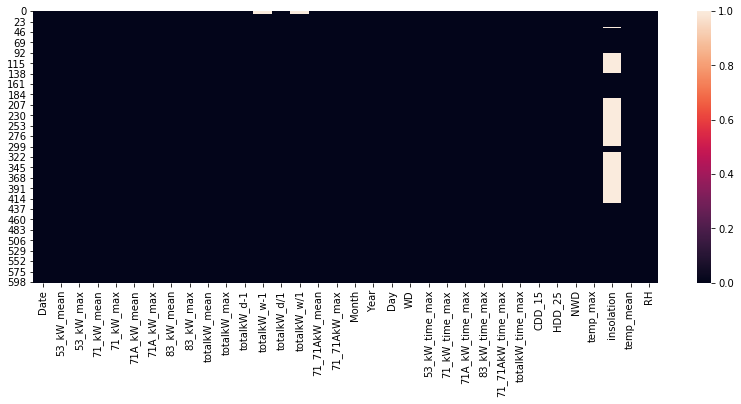

In [109]:
plt.figure(figsize=(14,5))
sns.heatmap(df.isnull())

In [110]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
insolation,267,44.50
totalkW_w/1,7,1.17
totalkW_w-1,7,1.17
totalkW_d/1,1,0.17
totalkW_d-1,1,0.17
83_kW_mean,0,0.00


In [111]:
df=df.tail(593)

In [112]:
df.head()

,Date,53_kW_mean,53_kW_max,71_kW_mean,71_kW_max,71A_kW_mean,71A_kW_max,83_kW_mean,83_kW_max,totalkW_mean,...,83_kW_time_max,71_71AkW_time_max,totalkW_time_max,CDD_15,HDD_25,NWD,temp_max,insolation,temp_mean,RH
7,15/06/2018,53.51,68.68,89.14,111.47,100.68,133.05,83.06,142.04,326.32,...,10:00,11:00,15:00,0.10,10.90,0,16.80,0.00,14.58,86.00
8,16/06/2018,40.60,52.50,63.07,75.51,63.25,93.49,35.89,55.38,202.80,...,10:00,03:00,03:00,0.00,11.40,0,16.20,0.00,14.50,84.50
9,17/06/2018,34.72,44.59,60.55,71.92,59.48,79.11,30.59,41.35,185.36,...,16:00,16:00,18:00,0.50,10.50,0,20.10,1.50,15.76,82.50
10,18/06/2018,51.10,63.65,81.48,104.28,98.71,143.83,86.08,151.38,317.51,...,10:00,15:00,15:00,1.30,9.00,0,22.00,3.60,16.82,81.50
11,19/06/2018,55.70,73.35,80.58,115.07,98.45,161.81,88.53,160.37,323.27,...,15:00,16:00,16:00,2.40,7.60,0,23.30,6.60,17.88,80.50


## 1.4 Reduce file size!

In [113]:
## Function to reduce the DF size

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [114]:
calc_df = reduce_mem_usage(df)


Mem. usage decreased to  0.06 Mb (61.0% reduction)


## 1.5 Data analysis!

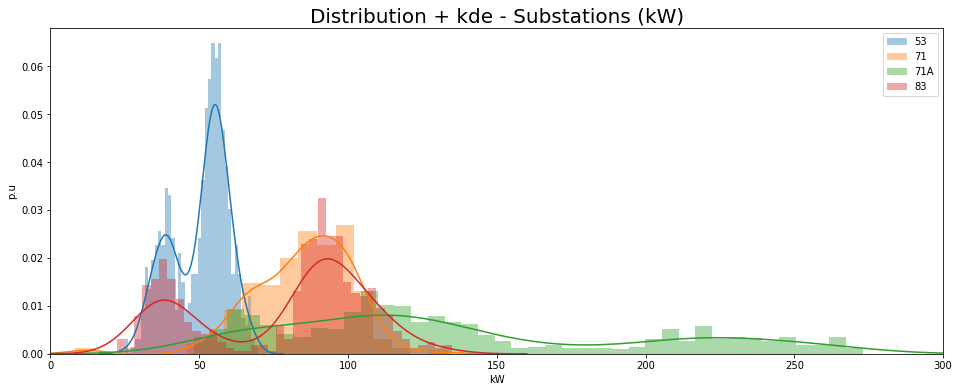

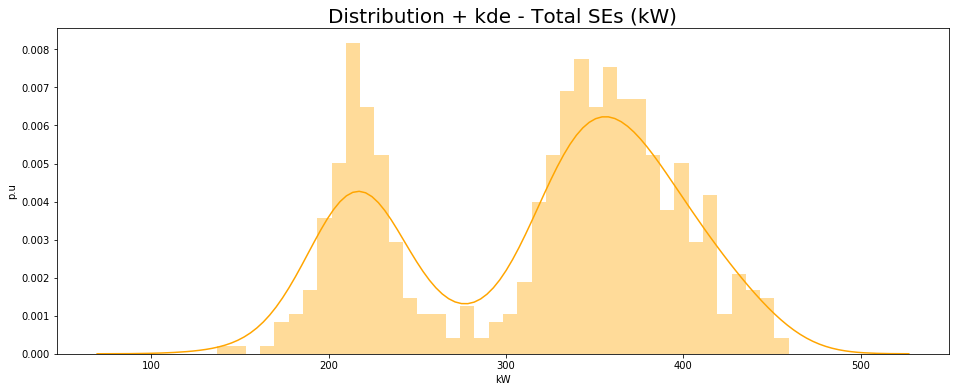

In [115]:
plt.figure(figsize=(16,6))
sns.distplot(df['53_kW_mean'].dropna(), bins=40, label='53')
sns.distplot(df[df['71_kW_mean']!=0]['71_kW_mean'].dropna(), bins=20, label='71')
sns.distplot(df['71A_kW_mean'].dropna(), bins=40, label='71A')
sns.distplot(df['83_kW_mean'].dropna(), bins=40, label='83')
plt.legend()
plt.xlim(0,300)
plt.xlabel("kW")
plt.title('Distribution + kde - Substations (kW)', fontsize=20);
plt.ylabel('p.u');

plt.figure(figsize=(16,6))
sns.distplot(df['totalkW_mean'].dropna(), bins=40, color='orange');
plt.title('Distribution + kde - Total SEs (kW)', fontsize=20);
plt.xlabel("kW")
plt.ylabel('p.u');

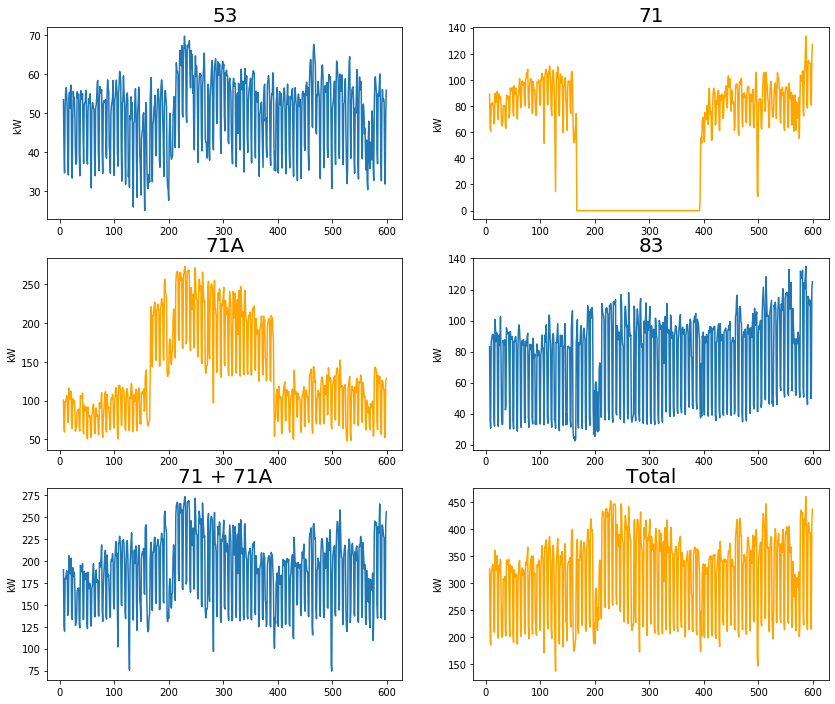

In [116]:
plt.figure(figsize=(14,12))
plt.subplot(321)
plt.plot(df['53_kW_mean'])
plt.ylabel('kW ')
plt.title('53', fontsize=20)

plt.subplot(322)
plt.plot(df['71_kW_mean'], color='orange')
plt.ylabel('kW')
plt.title('71', fontsize=20)

plt.subplot(323)
plt.plot(df['71A_kW_mean'], color='orange')
plt.ylabel('kW')
plt.title('71A', fontsize=20)

plt.subplot(324)
plt.plot(df['83_kW_mean'])
plt.ylabel('kW')
plt.title('83', fontsize=20)

plt.subplot(325)
plt.plot(df['71_71AkW_mean'])
plt.ylabel('kW')
plt.title('71 + 71A', fontsize=20)

plt.subplot(326)
plt.plot(df['totalkW_mean'], color='orange')
plt.ylabel('kW')
plt.title('Total', fontsize=20);

In [117]:
# Let's work with the 'totalkW' info!
total_cols = ['Date','totalkW_mean','totalkW_max','totalkW_time_max','totalkW_d-1','totalkW_w-1','totalkW_d/1','totalkW_w/1','Month','Year','Day','WD','CDD_15','HDD_25','NWD','temp_max','insolation','temp_mean','RH']
total_df = df[total_cols]

In [118]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 7 to 599
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              593 non-null    object 
 1   totalkW_mean      593 non-null    float16
 2   totalkW_max       593 non-null    float16
 3   totalkW_time_max  593 non-null    object 
 4   totalkW_d-1       593 non-null    float16
 5   totalkW_w-1       593 non-null    float16
 6   totalkW_d/1       593 non-null    float16
 7   totalkW_w/1       593 non-null    float16
 8   Month             593 non-null    int8   
 9   Year              593 non-null    int16  
 10  Day               593 non-null    int8   
 11  WD                593 non-null    int8   
 12  CDD_15            593 non-null    float16
 13  HDD_25            593 non-null    float16
 14  NWD               593 non-null    int8   
 15  temp_max          593 non-null    float16
 16  insolation        326 non-null    float16
 1

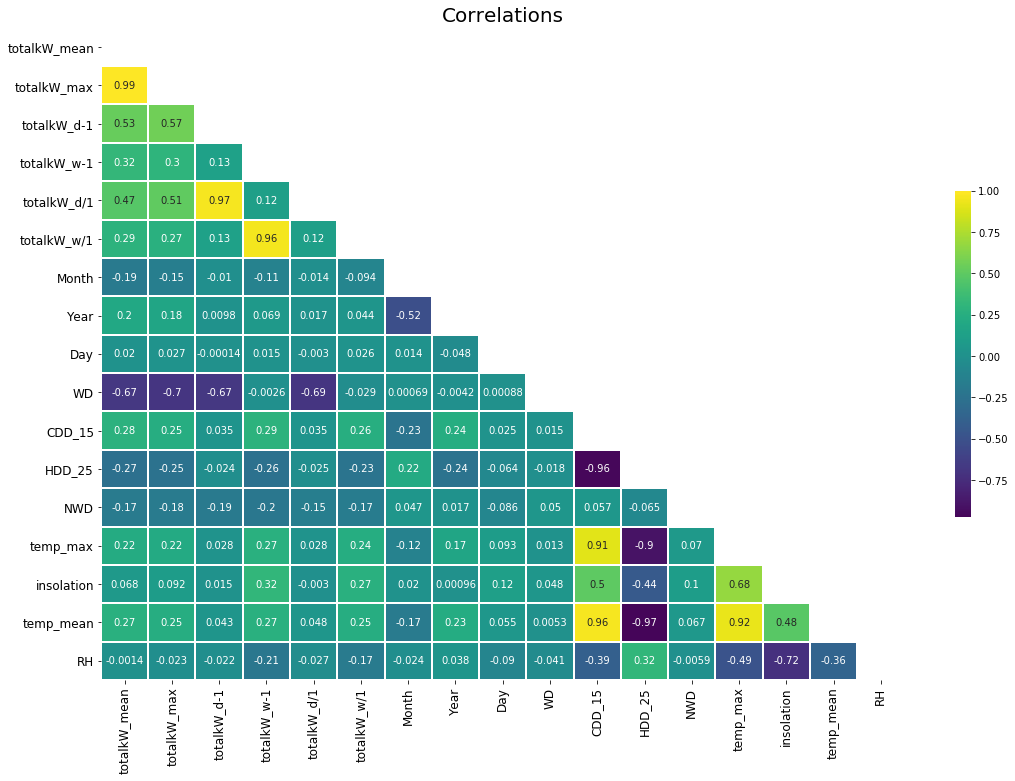

In [119]:
corr = total_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='viridis', vmax=1, center=0,
            square=False, linewidths=1, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlations', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12);

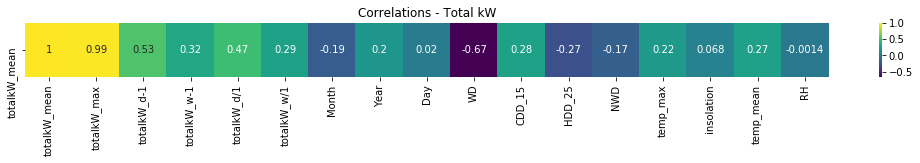

In [120]:
# focusing on the dependent variable
plt.figure(figsize=(18,1))
sns.heatmap(total_df.corr()[-18:1], mask=False, annot=True, cmap='viridis')
plt.title('Correlations - Total kW');

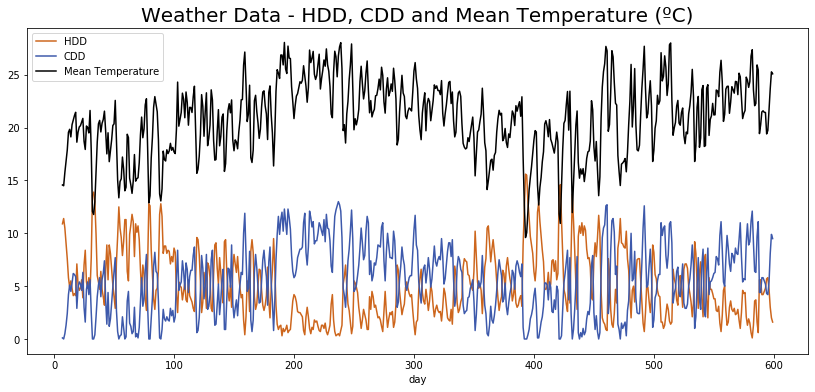

In [121]:
plt.figure(figsize=(14,6))
plt.plot(total_df['HDD_25'], color='#CD661D', label='HDD')
plt.plot(total_df['CDD_15'], color='#3D59AB', label='CDD')
plt.plot(total_df['temp_mean'], color='black', label='Mean Temperature')
plt.legend()
plt.xlabel('day')
plt.title('Weather Data - HDD, CDD and Mean Temperature (ºC)', fontsize = 20);

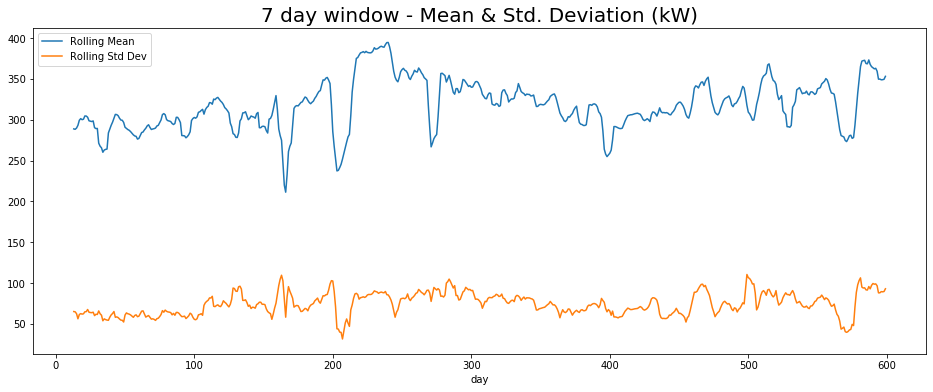

In [122]:
# here we will plot the rolling mean with a 7 window day period to analyze the weekly frequency
plt.figure(figsize=(16,6))
plt.plot(total_df['totalkW_mean'].rolling(window=7,center=False).mean(),label='Rolling Mean') # analyze the rolling mean considering a 7 days window
plt.plot(total_df['totalkW_mean'].rolling(window=7,center=False).std(),label='Rolling Std Dev')# analyze the rolling std dev considering a 7 days window
plt.legend()
plt.xlabel('day')
plt.title('7 day window - Mean & Std. Deviation (kW)', fontsize=20);

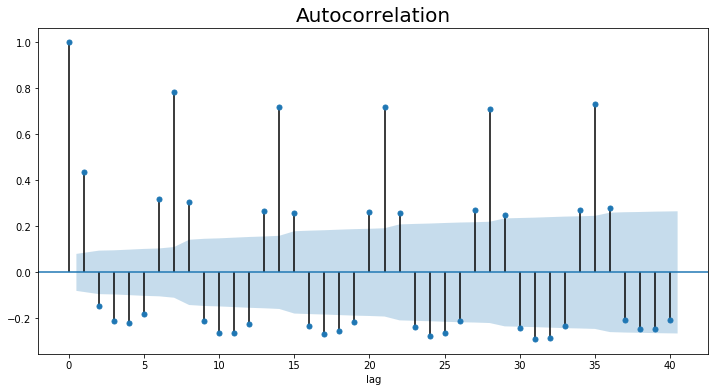

In [123]:
N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
corr_plot = plot_acf(total_df['totalkW_mean'].dropna(), lags=40, ax=ax)
#plt.show()
plt.title('Autocorrelation', fontsize=20)
plt.xlabel('lag');

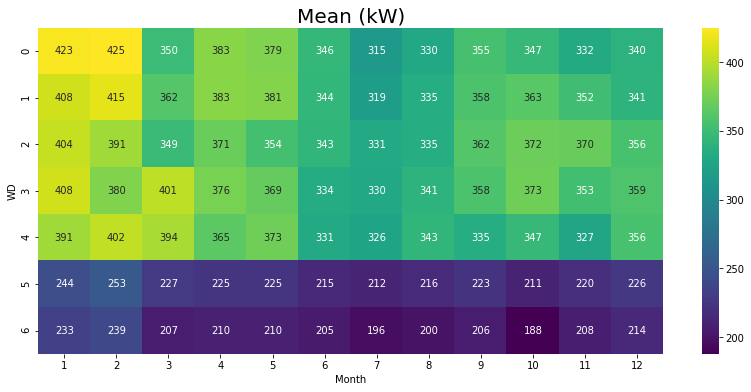

In [124]:
Consumo_WD_M = total_df[['WD','Month','totalkW_mean']].groupby(by=['WD','Month']).mean()['totalkW_mean'].unstack()
plt.figure(figsize=(14,6))
sns.heatmap(Consumo_WD_M.astype(int),cmap='viridis', annot=True, fmt='g')
plt.title("Mean (kW)", fontsize=20);

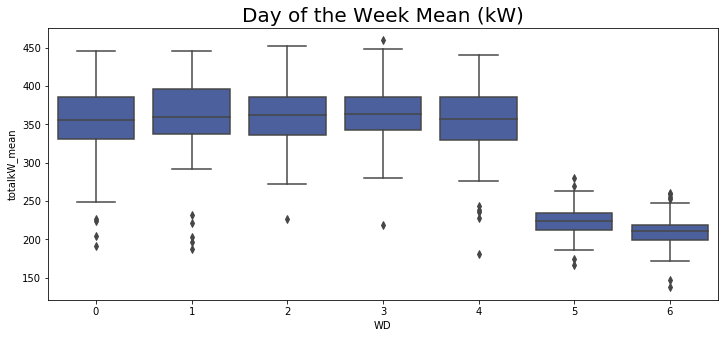

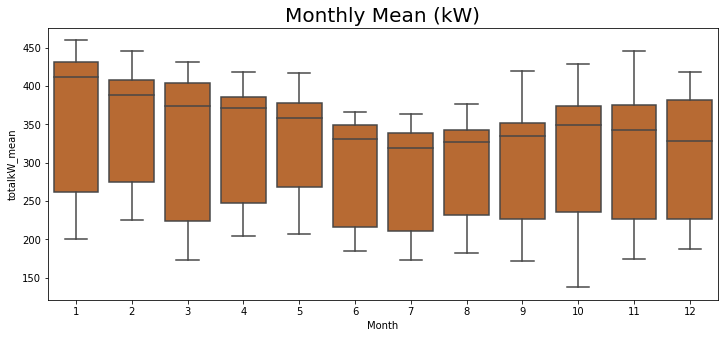

In [125]:
plt.figure(figsize=(12,5))
sns.boxplot(x='WD', y='totalkW_mean', data=total_df, color='#3D59AB')
plt.title("Day of the Week Mean (kW)", fontsize=20);

plt.figure(figsize=(12,5))
sns.boxplot(x='Month', y='totalkW_mean', data=total_df, color='#CD661D')
plt.title("Monthly Mean (kW)", fontsize=20);

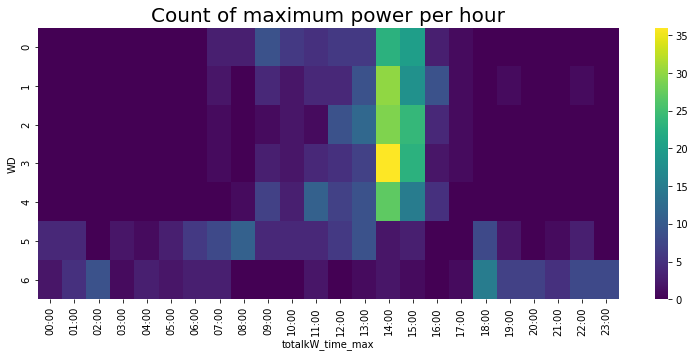

In [126]:
 # this plot shows the time during the day where it has the greatest power
count=total_df[['WD','totalkW_time_max','totalkW_max']].groupby(by=['WD','totalkW_time_max']).count()['totalkW_max'].unstack()
count[np.isnan(count)] = 0
plt.figure(figsize=(13,5))
sns.heatmap(count.dropna(), cmap='viridis')
plt.title("Count of maximum power per hour", fontsize=20);

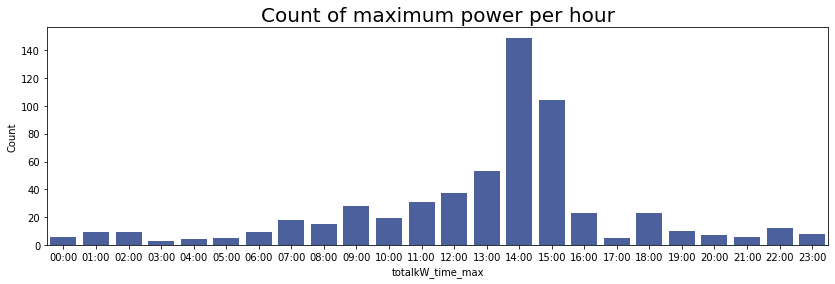

In [127]:
total = total_df['totalkW_time_max'].value_counts()
count  = pd.concat([total], axis=1, keys=['Count'])
count.reset_index(drop=False, inplace=True)
count.head(8)
count.sort_values(by=['index'], inplace=True, ascending=True)
plt.figure(figsize=(14,4))
sns.barplot(x='index', y='Count', data=count, color='#3D59AB')
plt.title("Count of maximum power per hour", fontsize=20);
plt.xlabel('totalkW_time_max');

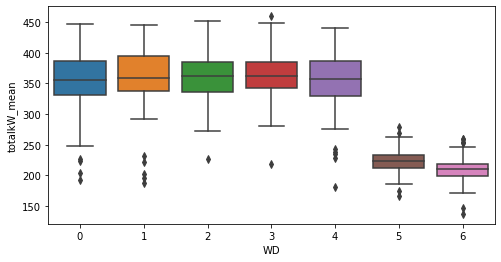

In [128]:
plt.figure(figsize=(8,4))
sns.boxplot(x='WD', y='totalkW_mean', data=total_df)

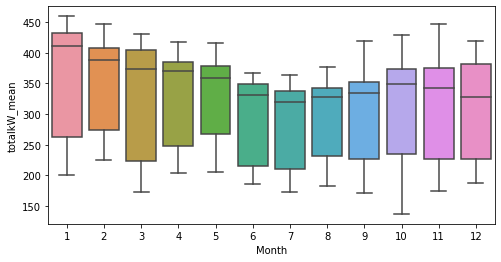

In [129]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Month', y='totalkW_mean', data=total_df)

## 1.6 Feature engineering - Dummy variables

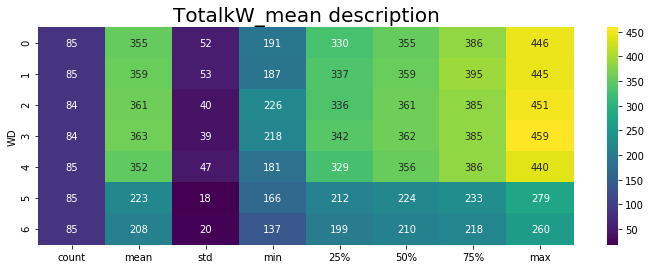

In [130]:
plt.figure(figsize=(12,4))
sns.heatmap(total_df.groupby(by='WD')['totalkW_mean'].describe().astype(int), cmap='viridis', annot=True , fmt='g');
plt.title('TotalkW_mean description', fontsize=20);

In [131]:
total_df['is_weekend'] = np.where(total_df['WD'].isin(['5','6']),1,0);

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



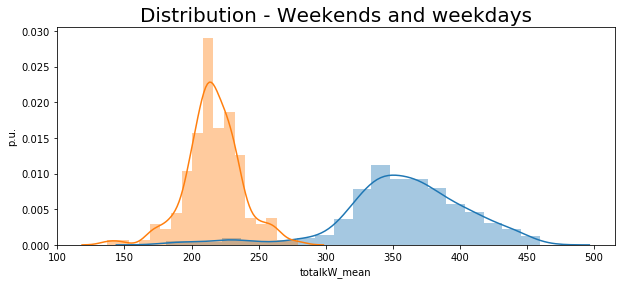

In [132]:
plt.figure(figsize=(10,4))
sns.distplot(total_df['totalkW_mean'].loc[(total_df['is_weekend'] == 0)])
sns.distplot(total_df['totalkW_mean'].loc[(total_df['is_weekend'] == 1)])
plt.ylabel('p.u.')
plt.title('Distribution - Weekends and weekdays', fontsize=20);


# 2 ANN MODEL!

In [133]:
# X is the independent variable - aka INPUT
# y is the dependent variable - aka OUTPUT

X = total_df.drop(['Date','Year','Day','totalkW_mean','totalkW_max','totalkW_time_max','insolation','RH'], axis=1).values
y = total_df['totalkW_mean'].values

# the model only works with arrays, not DF, that's why the ".values" on the code

### Since we dropped the columns cited above, we remain with the following INPUT variables:

totalkW_d-1

totalkW_w-1

totalkW_d/1

totalkW_w/1

Month

WD

CDD_15

HDD_25

NWD

temp_max

temp_mean

is_weekend

## 2.1 Splitting the data

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=102)

## 2.2 Normalizing the data

In [135]:
from sklearn.preprocessing import MinMaxScaler

In [136]:
scaler = MinMaxScaler()

In [137]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# ALWAYS TRAIN WITH THE X_TRAIN AND APPLY IT TO THE X_TEST

In [138]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [139]:
X_train.shape

(444, 1, 12)

In [140]:
X_test.shape

(149, 1, 12)

## 2.3 Creating the model!

In [141]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam


# Here I create a Long Short-Term Memory artificial recurrent neural network as a model
model_ann = Sequential()
model_ann.add(LSTM( units=4, input_shape=(1, 12), activation='sigmoid', return_sequences=True))
# first layer receiving the input. Sigmoid was choosing as an activation funcion in order to work properly for LSTM

model_ann.add(LSTM( units=2, input_shape=(1, 12), activation='linear',recurrent_activation='linear', return_sequences=False))
# the second layer work with a linear activation function to behave more in tune with our input data

model_ann.add(Dense(units=1,activation='linear'))
# finally a last layer with only one output, which is the respective mean power of the day

model_ann.compile(loss='mse', optimizer='adam')
# for the optimization model, the Minimum Squared Error is minimized as the objective function

## 2.4 Adding an Early Stop! 


In [143]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=250)
# added an early stop that is trigger when the difference of the validation loss at each epoch is minimum.

## 2.5 Fitting the MODEL!

In [144]:
model_ann.fit(x = X_train, 
          y = y_train, 
          epochs = 8000, 
          validation_data = (X_test, y_test), 
          batch_size = 128,
          callbacks=[early_stop],
          verbose=0
         );

# 8000 epochs to train the model
# 128 cases for updating the model parameters, which is the batch size

Epoch 06645: early stopping


## 2.6 Analyze the results

       loss  val_loss
6644 286.14    319.30


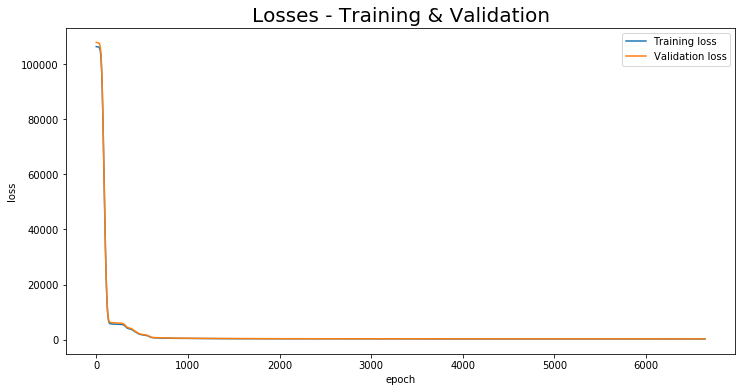

In [145]:
model_loss = pd.DataFrame(model_ann.history.history)
print(model_loss.tail(1))
plt.figure(figsize=(12,6))
plt.plot(model_loss['loss'], label = 'Training loss')
plt.plot(model_loss['val_loss'], label = 'Validation loss')
plt.legend()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Losses - Training & Validation", fontsize=20);

In [146]:
pd.options.display.float_format = "{:.2f}".format

predictions = model_ann.predict(X_test)

y_test_std_dev=y_test.astype(float).std()
print("Real Mean = %.2f" % total_df['totalkW_mean'].astype(float).mean())
print("y_test Mean = %.2f" % y_test.astype(float).mean())
print("y_test Std Dev = %.2f" % y_test.astype(float).std())

alpha = 5.0
lower_p = alpha / 2.0 # calculate lower percentile (e.g. 2.5)
lower = max(0.0, percentile(y_test, lower_p)) # retrieve observation at lower percentile
#print('y_test %.1fth percentile = %.2f' % (lower_p, lower)) # calculate upper percentile (e.g. 97.5)
upper_p = (100 - alpha) + (alpha / 2.0) # retrieve observation at upper percentile
upper = max(1.0, percentile(y_test, upper_p))
#print('y_test %.1fth percentile = %.2f' % (upper_p, upper))
print("Predictions Mean = %.2f" % predictions.astype(float).mean())
print("Predictions Std Dev = %.2f" % predictions.astype(float).std())

model_1_MAE = mean_absolute_error(y_test,predictions)
model_1_RMSE = np.sqrt(mean_squared_error(y_test,predictions))
model_1_EVS = explained_variance_score(y_test,predictions)

print("MAE = %.2f" % model_1_MAE)
print("RMSE = %.2f" % model_1_RMSE)
print("EVS = %.2f" % model_1_EVS)

Real Mean = 317.58
y_test Mean = 318.78
y_test Std Dev = 78.78
Predictions Mean = 320.25
Predictions Std Dev = 76.90
MAE = 12.17
RMSE = 17.87
EVS = 0.95


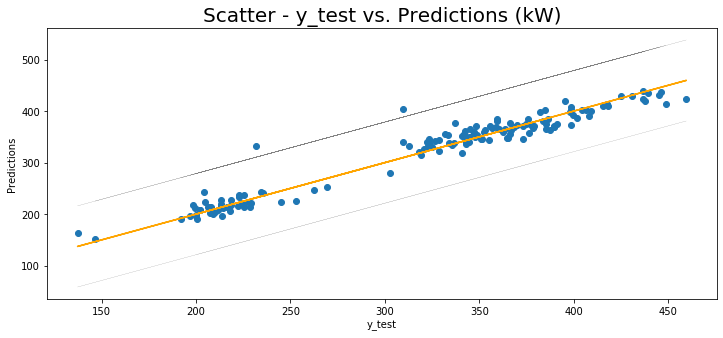

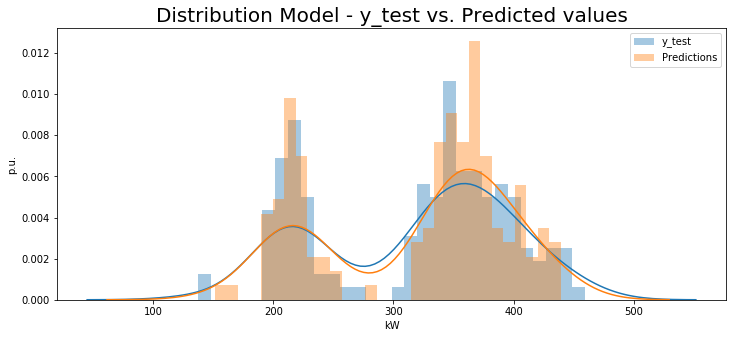

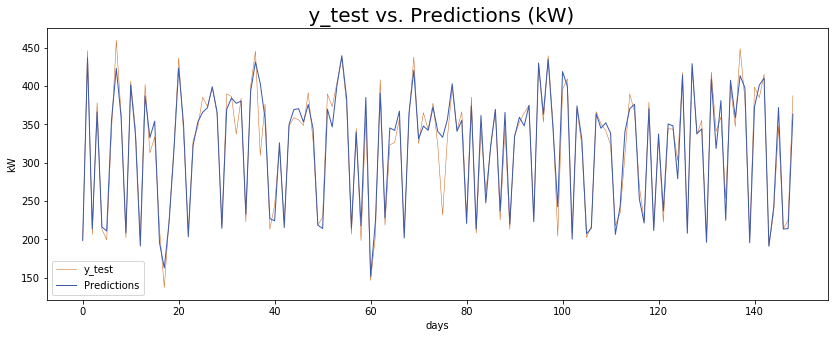

In [147]:
plt.figure(figsize=(12,5))
plt.scatter(y_test,predictions) # Our predictions

plt.plot(y_test,y_test, 'orange') # y=x line
plt.plot(y_test,y_test+y_test_std_dev,'grey', linewidth=.1) # y=x line
plt.plot(y_test,y_test-y_test_std_dev,'grey', linewidth=.1) # y=x line
plt.xlabel("y_test")
plt.ylabel("Predictions")
plt.title("Scatter - y_test vs. Predictions (kW)", fontsize=20);

plt.figure(figsize=(12,5)) # Plot predictions and the real values together
sns.distplot(y_test, label='y_test', bins=30)
sns.distplot(predictions, label='Predictions', bins=30)
plt.title("Distribution Model - y_test vs. Predicted values", fontsize=20);
plt.legend()
plt.ylabel("p.u.")
plt.xlabel("kW");

plt.figure(figsize=(14,5))
plt.plot(y_test, '#CD661D', linewidth=.5, label='y_test')
plt.plot(predictions, '#3D59AB',linewidth=1, label='Predictions')
plt.title(" y_test vs. Predictions (kW)", fontsize=20);
plt.legend()
plt.ylabel("kW")
plt.xlabel("days");

Skewness = -2.03
Kurtosis = 9.95


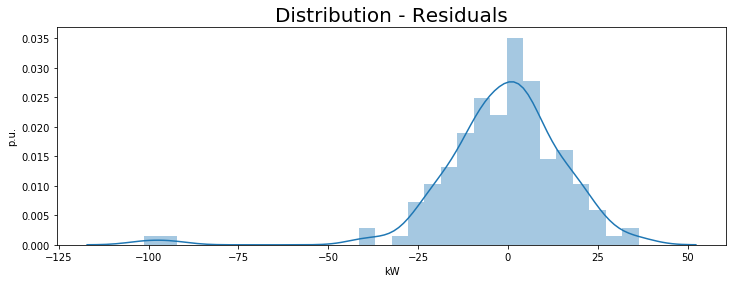

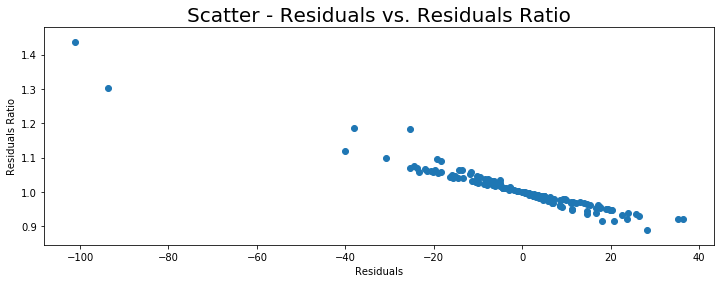

In [148]:
y_test_pd = DataFrame(y_test)
predictions_pd = DataFrame(predictions)
comparison  = pd.concat([y_test_pd, predictions_pd], axis=1, keys=['y_test', 'predictions'])
comparison['resid'] = comparison['y_test'] -  comparison['predictions']
comparison['resid_ratio'] = (comparison['predictions'] / comparison['y_test'])
comparison['residsqr'] = comparison['resid']*comparison['resid']

plt.figure(figsize=[12,4])
sns.distplot((comparison['resid']), bins=30)
plt.title('Distribution - Residuals', fontsize=20);
plt.xlabel("kW")
plt.ylabel("p.u.");

print("Skewness = %.2f" % comparison['resid'].skew())
print("Kurtosis = %.2f" % comparison['resid'].kurt())

plt.figure(figsize=[12,4])
plt.scatter(comparison['resid'],comparison['resid_ratio'])
plt.title('Scatter - Residuals vs. Residuals Ratio', fontsize=20);
plt.xlabel("Residuals")
plt.ylabel("Residuals Ratio");

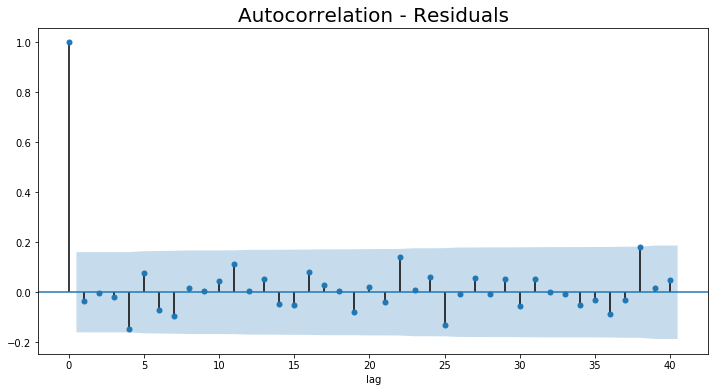

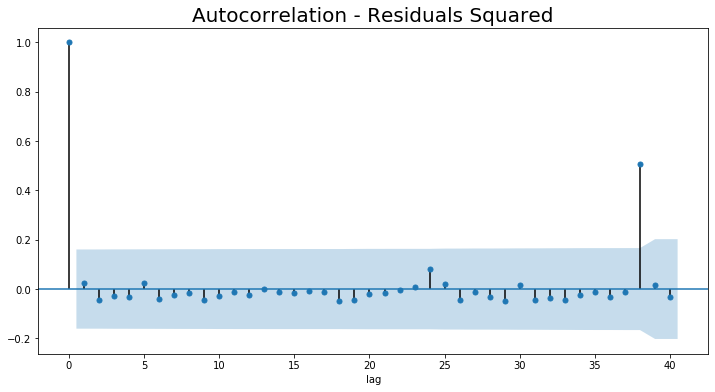

In [149]:
N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
corr_plot = plot_acf(comparison['resid'].dropna(), lags=40, ax=ax)
#plt.show()
plt.title('Autocorrelation - Residuals', fontsize=20)
plt.xlabel('lag');

N, M = 12, 6
fig, ax = plt.subplots(figsize=(N, M))
corr_plot = plot_acf(comparison['residsqr'].dropna(), lags=40, ax=ax)
#plt.show()
plt.title('Autocorrelation - Residuals Squared', fontsize=20)
plt.xlabel('lag');

# 3 Prediction Model

In [150]:
X_df = total_df.drop(['Date','Day','Year','totalkW_max','totalkW_mean','insolation','totalkW_time_max','RH'], axis=1)
X_df = X_df.reset_index(drop=True)

y_df = total_df['totalkW_mean']
y_df = pd.concat([y_df], axis=1, keys="total")
y_df = y_df.reset_index(drop=True)

initial_values = 30

nl3 = y_df.head(initial_values)
nl4 = X_df.head(initial_values)


## 3.1 For loop

In [151]:
i=len(nl3)-1
j=1
pred=0
steps=564
for j in range(1,steps):
    nl4 = nl4.append(pd.Series([nl3.loc[i][0]-nl3.loc[i-1][0]] + [nl3.loc[i][0]-nl3.loc[i-7][0]] + [nl3.loc[i][0]/nl3.loc[i-1][0]] + [nl3.loc[i][0]/nl3.loc[i-7][0]] + [X_df.loc[i][4]] + [nl4.loc[i-6][5]] + [X_df.loc[i][6]] + [X_df.loc[i][7]] + [X_df.loc[i][8]] + [X_df.loc[i][9]] + [X_df.loc[i][10]] + [nl4.loc[i-6][11]],  index=nl4.columns), ignore_index=True)
    #print(nl4)
    nly = nl4.tail(1).values
    nly = scaler.transform(nly)
    nly = np.reshape(nly, (nly.shape[0], 1, nly.shape[1]))
    pred = float(model_ann.predict(nly))
    #print(pred)
    nl3 = nl3.append(pd.Series(pred, index=nl3.columns), ignore_index=True)
    j=j+1
    i=i+1
# nl4 are the INPUTS

In [152]:
df_real = y_df['t']
df_real = df_real.tail(steps)
df_pred = nl3.tail(steps)

model_2_df = nl4
model_2_df['predictions'] = df_pred
model_2_df['real'] = df_real

# join the predictions and the real values to the used DF, so we can correlate all the dependent and independent variables

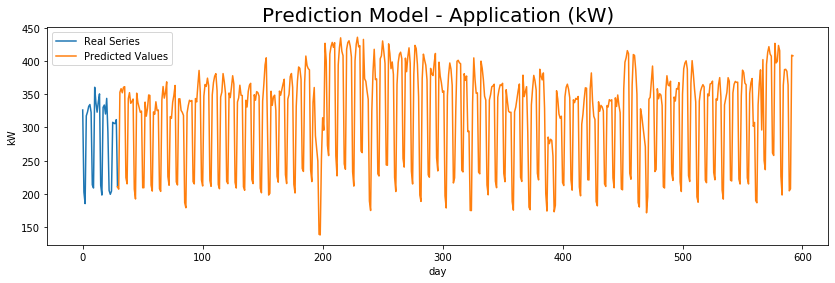

In [153]:
plt.figure(figsize=(14,4))
plt.plot(nl3.head(initial_values),label='Real Series')
plt.plot(nl3.tail(steps), label='Predicted Values')
plt.legend()
plt.title("Prediction Model - Application (kW)", fontsize=20)
plt.ylabel("kW")
plt.xlabel("day");

## 3.2 Analyze the results

In [154]:
df_real = y_df['t']
df_real = df_real.tail(steps)
df_pred = nl3.tail(steps)

y_test_std_dev=y_test.astype(float).std()
print("Real Mean = %.2f" % df_real.astype(float).mean())
print("Real Std Dev = %.2f" % df_real.astype(float).std())

alpha = 5.0
lower_p = alpha / 2.0 # calculate lower percentile (e.g. 2.5)
lower = max(0.0, percentile(df_real, lower_p)) # retrieve observation at lower percentile
#print('Real %.1fth percentile = %.2f' % (lower_p, lower)) # calculate upper percentile (e.g. 97.5)
upper_p = (100 - alpha) + (alpha / 2.0) # retrieve observation at upper percentile
upper = max(1.0, percentile(df_real, upper_p))
#print('Real %.1fth percentile = %.2f' % (upper_p, upper))
print("Predictions Mean = %.2f" % df_pred.astype(float).mean())
print("Predictions Std Dev = %.2f" % df_pred.astype(float).std())

model_1_app_MAE = mean_absolute_error(df_real,df_pred)
model_1_app_RMSE = np.sqrt(mean_squared_error(df_real,df_pred))
model_1_app_EVS = explained_variance_score(df_real,df_pred)
                           
print("MAE = %.2f" % model_1_app_MAE)
print("RMSE = %.2f" % model_1_app_RMSE)
print("EVS = %.2f" % model_1_app_EVS)

Real Mean = 319.11
Real Std Dev = 76.95
Predictions Mean = 319.25
Predictions Std Dev = 73.64
MAE = 21.76
RMSE = 34.43
EVS = 0.80


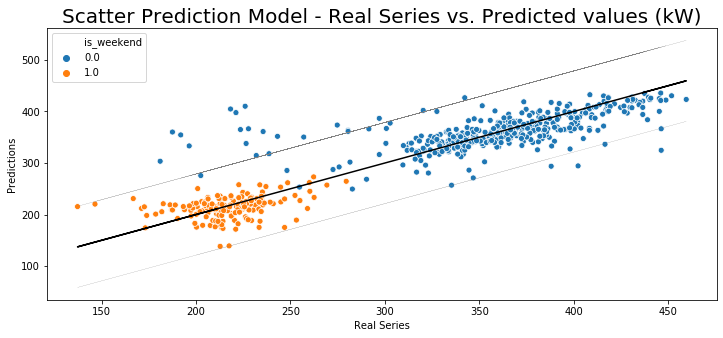

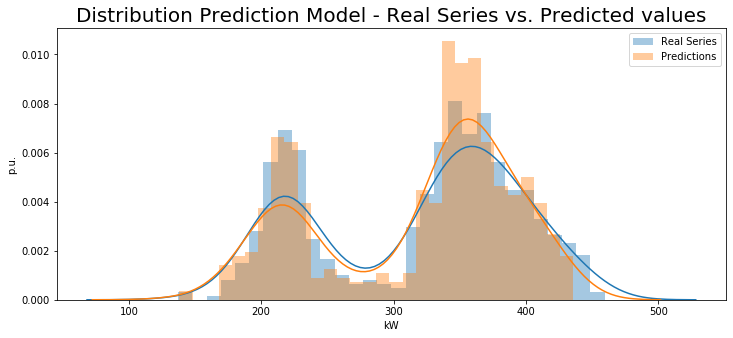

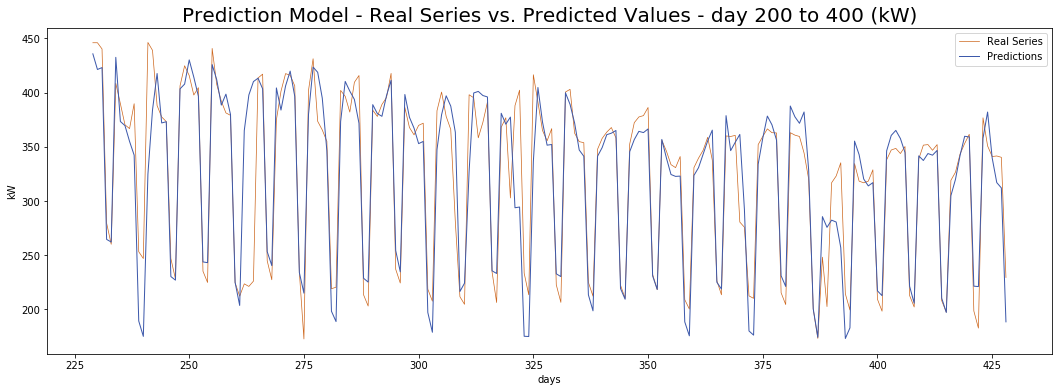

In [155]:
plt.figure(figsize=(12,5)) 
sns.scatterplot(x='real', y='predictions', data=model_2_df, hue='is_weekend')
plt.plot(df_real,df_real,'black')  # y=x line
plt.plot(y_test,y_test+y_test_std_dev,'grey', linewidth=.1) # y=x line
plt.plot(y_test,y_test-y_test_std_dev,'grey', linewidth=.1) # y=x line
plt.title("Scatter Prediction Model - Real Series vs. Predicted values (kW)", fontsize=20)
plt.xlabel("Real Series")
plt.ylabel("Predictions");

plt.figure(figsize=(12,5)) # Plot predictions and the real values together
sns.distplot(df_real, label='Real Series', bins=30)
sns.distplot(df_pred, label='Predictions', bins=30)
plt.title("Distribution Prediction Model - Real Series vs. Predicted values", fontsize=20)
plt.legend()
plt.ylabel("p.u.")
plt.xlabel("kW");

plt.figure(figsize=(18,6)) # Plot predictions and the real values together
plt.plot(df_real[200:400], '#CD661D', label= 'Real Series', linewidth=.7) # get only a part of it
plt.plot(df_pred[200:400], '#3D59AB', label= 'Predictions', linewidth=1)
plt.title("Prediction Model - Real Series vs. Predicted Values - day 200 to 400 (kW)", fontsize=20)
plt.xlabel("days")
plt.ylabel("kW");
plt.legend();

Skewness: -1.76
Kurtosis: 7.80


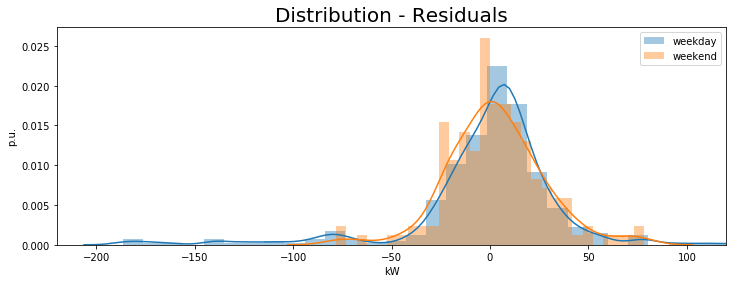

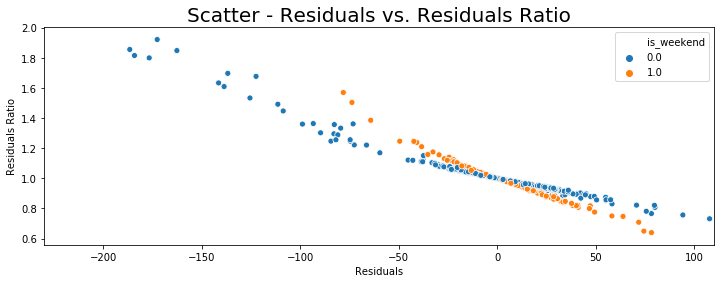

In [156]:
model_2_df['resid'] = model_2_df['real'] -  model_2_df['predictions']
model_2_df['resid_ratio'] = (model_2_df['predictions'] / model_2_df['real'])
model_2_df['residsqr'] = model_2_df['resid']*model_2_df['resid']

plt.figure(figsize=[12,4])
sns.distplot(model_2_df['resid'].loc[(model_2_df['is_weekend'] == 0)], bins=30, label='weekday')
sns.distplot(model_2_df['resid'].loc[(model_2_df['is_weekend'] == 1)], bins=30, label='weekend')
plt.title('Distribution - Residuals', fontsize=20)
plt.xlabel("kW")
plt.xlim(-220,120)
plt.legend()
plt.ylabel("p.u.");

print("Skewness: %.2f" % model_2_df['resid'].skew())
print("Kurtosis: %.2f" % model_2_df['resid'].kurt())

plt.figure(figsize=[12,4])
sns.scatterplot(x='resid', y='resid_ratio', data=model_2_df, hue='is_weekend')
plt.title('Scatter - Residuals vs. Residuals Ratio', fontsize=20)
plt.xlabel("Residuals")
plt.xlim(-230,110)
plt.ylabel("Residuals Ratio");

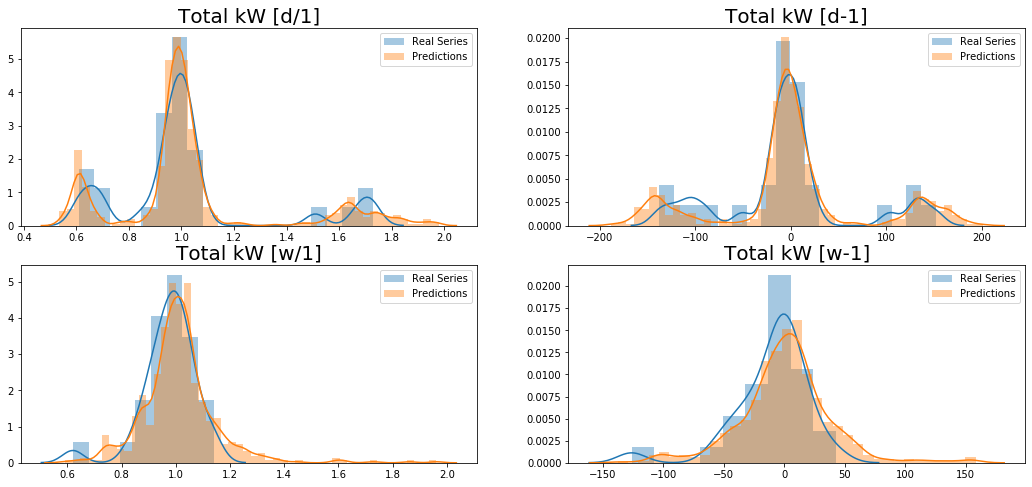

In [157]:
 #comparing the distribution of the following values

plt.figure(figsize=[18,8])
plt.subplot(221)
sns.distplot(nl4['totalkW_d/1'].head(initial_values), label='Real Series')
sns.distplot(nl4['totalkW_d/1'].tail(steps), label='Predictions')
plt.legend()
plt.title("Total kW [d/1]", fontsize=20)
plt.xlabel("");

plt.subplot(223)
sns.distplot(nl4['totalkW_w/1'].head(initial_values), label='Real Series')
sns.distplot(nl4['totalkW_w/1'].tail(steps), label='Predictions')
plt.legend()
plt.title("Total kW [w/1]", fontsize=20)
plt.xlabel("");

plt.subplot(222)
sns.distplot(nl4['totalkW_d-1'].head(initial_values), label='Real Series')
sns.distplot(nl4['totalkW_d-1'].tail(steps), label='Predictions')
plt.legend()
plt.title("Total kW [d-1]", fontsize=20)
plt.xlabel("");

plt.subplot(224)
sns.distplot(nl4['totalkW_w-1'].head(initial_values), label='Real Series')
sns.distplot(nl4['totalkW_w-1'].tail(steps), label='Predictions')
plt.legend()
plt.title("Total kW [w-1]", fontsize=20)
plt.xlabel("");

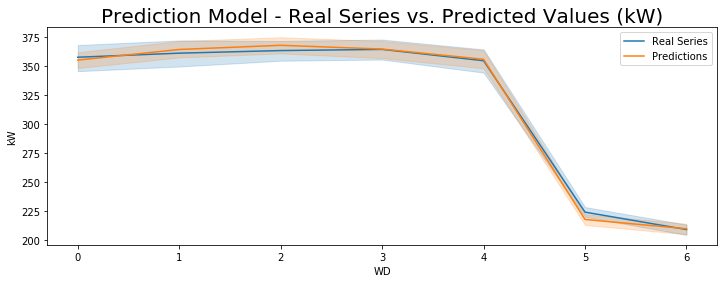

In [158]:
plt.figure(figsize=(12,4))
sns.lineplot(x='WD', y='real', data=model_2_df, label='Real Series')
sns.lineplot(x='WD', y='predictions', data=model_2_df, label='Predictions');
plt.title("Prediction Model - Real Series vs. Predicted Values (kW)", fontsize=20)
plt.ylabel("kW")
plt.legend();

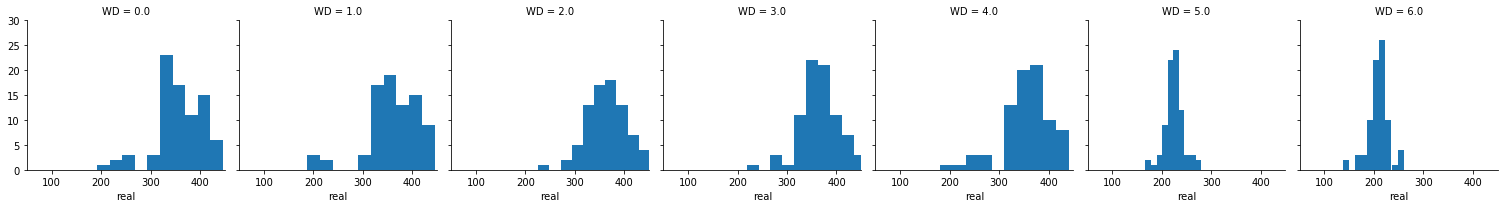

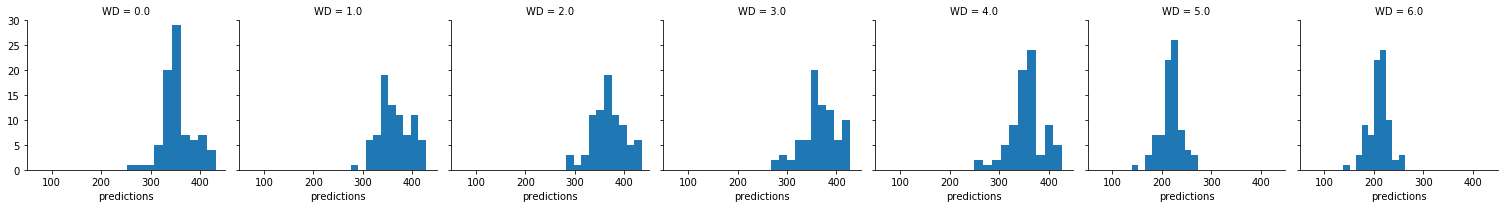

In [159]:
g = sns.FacetGrid(model_2_df, col='WD', xlim=(50,450), ylim=(0,30))
g = g.map(plt.hist, 'real')
h = sns.FacetGrid(model_2_df, col='WD', xlim=(50,450), ylim=(0,30))
h = h.map(plt.hist, 'predictions')

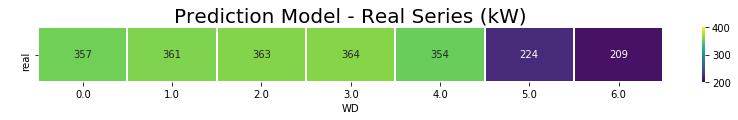

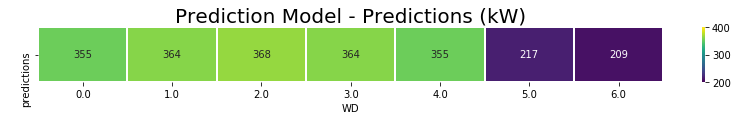

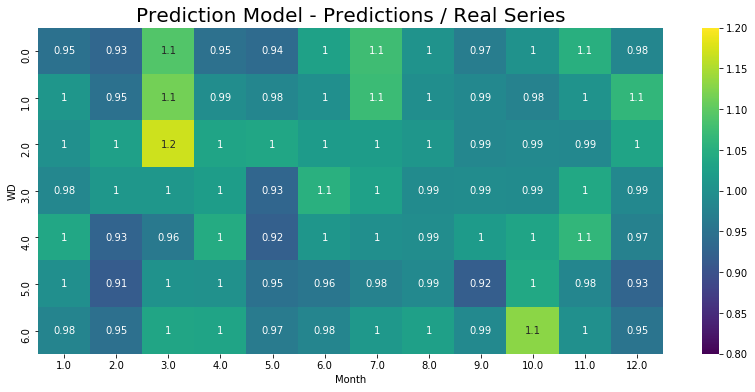

In [160]:
plt.figure(figsize=(14,1))
rwd = model_2_df.pivot_table(values='real',columns='WD')
sns.heatmap(rwd.astype(int), annot=True,linecolor='white',linewidths=1, vmin=200, vmax=400, cmap='viridis', fmt='g')
plt.title("Prediction Model - Real Series (kW)", fontsize=20)
plt.ylabel(" ");

plt.figure(figsize=(14,1));
pwd = model_2_df.pivot_table(values='predictions',columns='WD')
sns.heatmap(pwd.astype(int), annot=True,linecolor='white',linewidths=1, vmin=200, vmax=400, cmap='viridis', fmt='g')
plt.title("Prediction Model - Predictions (kW)", fontsize=20)
plt.ylabel(" ");

Pred_Power_WD_M = model_2_df[['WD','Month','predictions']].groupby(by=['WD','Month']).mean()['predictions'].unstack()
Consumo_WD_M = total_df[['WD','Month','totalkW_mean']].groupby(by=['WD','Month']).mean()['totalkW_mean'].unstack()
plt.figure(figsize=(14,6))
comp=(Pred_Power_WD_M/Consumo_WD_M)
sns.heatmap(comp,cmap='viridis', annot=True, vmin=0.8, vmax=1.2)
plt.title("Prediction Model - Predictions / Real Series", fontsize=20);

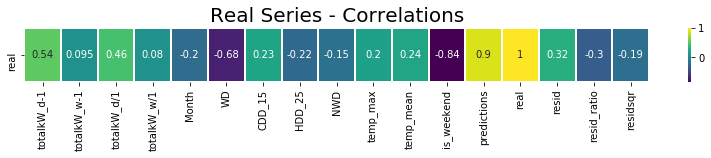

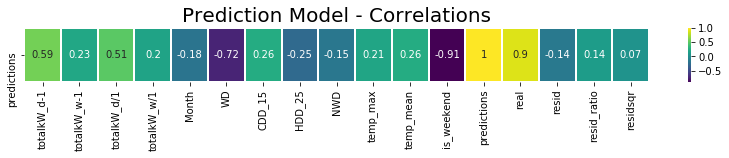

In [161]:
plt.figure(figsize=(14,1))
sns.heatmap(model_2_df.corr()[-4:-3:18], annot=True,linecolor='white',linewidths=1, cmap='viridis')
plt.title("Real Series - Correlations", fontsize=20);

plt.figure(figsize=(14,1))
sns.heatmap(model_2_df.corr()[-5:-4:18], annot=True,linecolor='white',linewidths=1, cmap='viridis')
plt.title("Prediction Model - Correlations", fontsize=20);

# 4 Model Comparing

In [162]:
# Models
from sklearn.linear_model import LinearRegression, BayesianRidge, LassoLars
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor

# Metrics and Grid Search
from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV

In [163]:
X = total_df.drop(['Date','Year','Day','totalkW_mean','totalkW_max','totalkW_time_max','insolation','RH'], axis=1).values
y = total_df['totalkW_mean'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

scaler = MinMaxScaler()
scaler.fit(X_train) 
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

In [164]:
# Creating a predefined function to test the models
def modelfit(model):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print("MAE = %.2f" % mean_absolute_error(y_test,preds))
    print("RMSE = %.2f" % np.sqrt(mean_squared_error(y_test,preds)))
    print("EVS = %.2f" % explained_variance_score(y_test,preds));


## 4.1 Testing models

In [165]:
# Linear Regression

lm = LinearRegression(n_jobs = 10000)
modelfit(lm)

MAE = 18.28
RMSE = 23.83
EVS = 0.89


In [166]:
# Random Forest Regressor

rf = RandomForestRegressor(n_jobs = 1000, verbose=0)
modelfit(rf)

MAE = 12.64
RMSE = 19.67
EVS = 0.92


In [167]:
# XGBoost
xg = XGBRegressor(learning_rate=0.1, n_estimators=5000)
modelfit(xg)

MAE = 12.33
RMSE = 18.48
EVS = 0.93


In [168]:
# Decision Tree
dt = DecisionTreeRegressor()
modelfit(dt)

MAE = 14.88
RMSE = 21.80
EVS = 0.91


In [169]:
# Bayesian Linear Model
br = BayesianRidge(alpha_1=1e-06, alpha_2=0.5, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=10,
              normalize=False, tol=0.1, verbose=False)
modelfit(br)

MAE = 18.57
RMSE = 24.16
EVS = 0.88


In [170]:
# Lasso Lars
ls = LassoLars()
modelfit(ls)

MAE = 31.43
RMSE = 39.18
EVS = 0.69


## 4.2 Optimizing parameters - XGBoost

In [171]:
#apply an array of learning rate values in order to get the one with the lowest error
import numpy as np
size=100
lr = np.linspace(0.01,1,size)
j = 0
MAE = np.zeros(size)
RMSE = np.zeros(size)
EVS = np.zeros(size)

for j in range(0,len(lr)-1):
    xg = XGBRegressor(learning_rate=lr[j], n_estimators=5000)
    xg.fit(X_train, y_train)
    preds = xg.predict(X_test)
    MAE[j] = mean_absolute_error(y_test,preds)
    RMSE[j] = np.sqrt(mean_squared_error(y_test,preds))
    EVS[j] = explained_variance_score(y_test,preds)

xg_df = pd.DataFrame(MAE[:-1], columns = ['MAE']) 
xg_df['RMSE'] = RMSE[:-1]
xg_df['EVS'] = EVS[:-1]
xg_df['lr'] = lr[:-1]


In [172]:
xg_df.sort_values(by=['MAE'], inplace=True, ascending=True)

model_alt_MAE = xg_df['MAE'].min()
model_alt_RMSE = xg_df['RMSE'].min()
model_alt_EVS = xg_df['EVS'].max()

print("MAE = %.2f" % model_alt_MAE)
print("RMSE = %.2f" % model_alt_RMSE)
print("EVS = %.2f" % model_alt_EVS)
print("learning rate = %.2f" % xg_df['lr'].head(1))
lr_ideal = xg_df['lr'].head(1).astype(float).values
xg_df.head(3)

MAE = 12.16
RMSE = 17.95
EVS = 0.93
learning rate = 0.14


,MAE,RMSE,EVS,lr
13,12.16,18.19,0.93,0.14
15,12.24,18.29,0.93,0.16
29,12.30,17.95,0.93,0.30


In [173]:
alt_model = XGBRegressor(learning_rate=0.14, n_estimators=5000)
alt_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.14, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=5000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

## 4.3 Applying XGBoost

In [174]:
X_df = total_df.drop(['Date','Day','Year','totalkW_max','totalkW_mean','insolation','totalkW_time_max','RH'], axis=1)
X_df = X_df.reset_index(drop=True)

y_df = total_df['totalkW_mean']
y_df = pd.concat([y_df], axis=1, keys="total")
y_df = y_df.reset_index(drop=True)

initial_values = 30

nl1 = y_df.head(initial_values)
nl2 = X_df.head(initial_values)

In [175]:
i=len(nl1)-1
j=1
pred=0
steps=564
for j in range(1,steps):
    nl2 = nl2.append(pd.Series([nl1.loc[i][0]-nl1.loc[i-1][0]] + [nl1.loc[i][0]-nl1.loc[i-7][0]] + [nl1.loc[i][0]/nl1.loc[i-1][0]] + [nl1.loc[i][0]/nl1.loc[i-7][0]] + [X_df.loc[i][4]] + [nl2.loc[i-6][5]] + [X_df.loc[i][6]] + [X_df.loc[i][7]] + [X_df.loc[i][8]] + [X_df.loc[i][9]] + [X_df.loc[i][10]] + [nl2.loc[i-6][11]],  index=nl2.columns), ignore_index=True)
    #print(nl4)
    nly = nl2.tail(1).values
    nly = scaler.transform(nly)
    #nly = np.reshape(nly, (nly.shape[0], 1, nly.shape[1]))
    pred = float(alt_model.predict(nly))
    #print(pred)
    nl1 = nl1.append(pd.Series(pred, index=nl3.columns), ignore_index=True)
    j=j+1
    i=i+1

## 4.4 Analyze the results

In [176]:
df_real_alt = y_df['t']
df_real_alt = df_real.tail(steps)
df_pred_alt = nl1.tail(steps)

model_alt_df = nl2
model_alt_df['predictions'] = df_pred_alt
model_alt_df['real'] = df_real_alt

y_test_std_dev=y_test.astype(float).std()
print("Real Mean = %.2f" % df_real_alt.astype(float).mean())
print("Real Std Dev = %.2f" % df_real_alt.astype(float).std())

alpha = 5.0
lower_p = alpha / 2.0 # calculate lower percentile (e.g. 2.5)
lower = max(0.0, percentile(df_real_alt, lower_p)) # retrieve observation at lower percentile
#print('Real %.1fth percentile = %.2f' % (lower_p, lower)) # calculate upper percentile (e.g. 97.5)
upper_p = (100 - alpha) + (alpha / 2.0) # retrieve observation at upper percentile
upper = max(1.0, percentile(df_real_alt, upper_p))
#print('Real %.1fth percentile = %.2f' % (upper_p, upper))
print("Predictions Mean = %.2f" % df_pred_alt.astype(float).mean())
print("Predictions Std Dev = %.2f" % df_pred_alt.astype(float).std())

model_alt_app_MAE = mean_absolute_error(df_real_alt,df_pred_alt)
model_alt_app_RMSE = np.sqrt(mean_squared_error(df_real_alt,df_pred_alt))
model_alt_app_EVS = explained_variance_score(df_real_alt,df_pred_alt)
                             
print("MAE = %.2f" % model_alt_app_MAE)
print("RMSE = %.2f" % model_alt_app_RMSE)
print("EVS = %.2f" % model_alt_app_EVS)

Real Mean = 319.11
Real Std Dev = 76.95
Predictions Mean = 322.77
Predictions Std Dev = 73.14
MAE = 20.39
RMSE = 33.83
EVS = 0.81


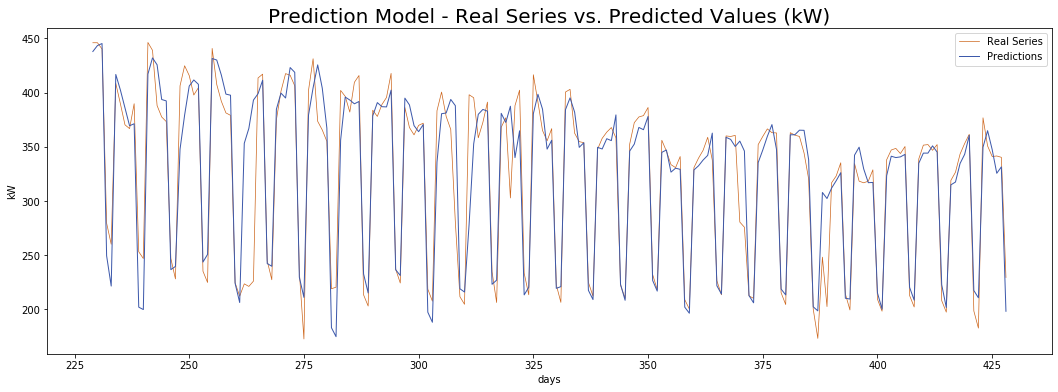

In [177]:
plt.figure(figsize=(18,6)) # Plot predictions and the real values together
plt.plot(df_real_alt[200:400], '#CD661D', label= 'Real Series', linewidth=.7)
plt.plot(df_pred_alt[200:400], '#3D59AB', label= 'Predictions', linewidth=1)
plt.title("Prediction Model - Real Series vs. Predicted Values (kW)", fontsize=20)
plt.xlabel("days")
plt.ylabel("kW");
plt.legend();

Skewness: -2.26
Kurtosis: 8.76


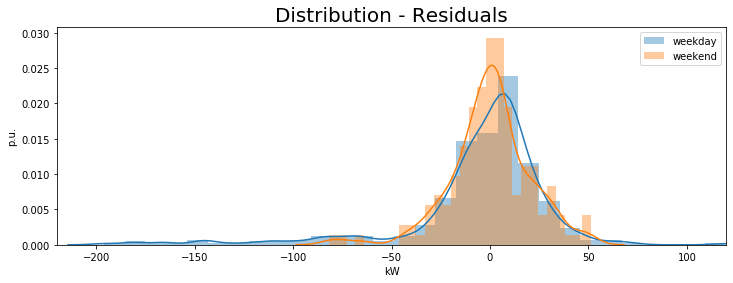

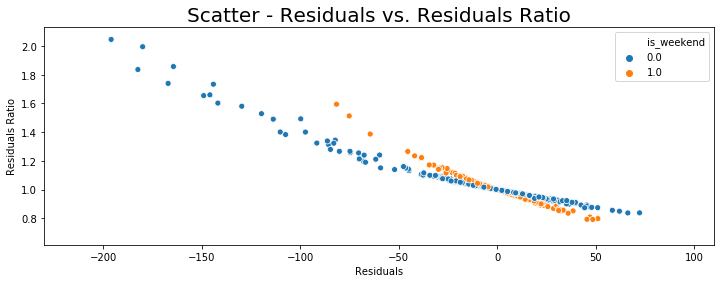

In [178]:
model_alt_df['resid'] = model_alt_df['real'] -  model_alt_df['predictions']
model_alt_df['resid_ratio'] = (model_alt_df['predictions'] / model_alt_df['real'])
model_alt_df['residsqr'] = model_alt_df['resid']*model_alt_df['resid']

plt.figure(figsize=[12,4])
sns.distplot(model_alt_df['resid'].loc[(model_alt_df['is_weekend'] == 0)], bins=30, label='weekday')
sns.distplot(model_alt_df['resid'].loc[(model_alt_df['is_weekend'] == 1)], bins=30, label='weekend')
plt.title('Distribution - Residuals', fontsize=20)
plt.xlabel("kW")
plt.xlim(-220,120)
plt.legend()
plt.ylabel("p.u.");

print("Skewness: %.2f" % model_alt_df['resid'].skew())
print("Kurtosis: %.2f" % model_alt_df['resid'].kurt())

plt.figure(figsize=[12,4])
sns.scatterplot(x='resid', y='resid_ratio', data=model_alt_df, hue='is_weekend')
plt.title('Scatter - Residuals vs. Residuals Ratio', fontsize=20)
plt.xlabel("Residuals")
plt.xlim(-230,110)
plt.ylabel("Residuals Ratio");

# 5 Model comparison - ANN LSTM vs. XGBoost

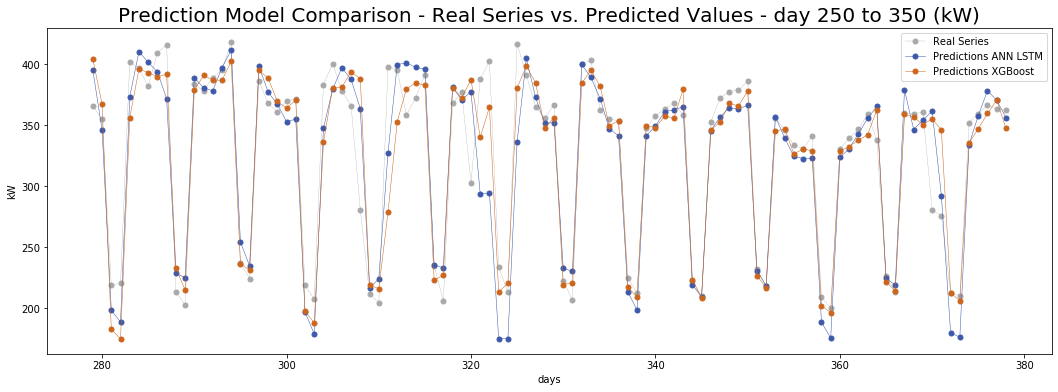

In [179]:
plt.figure(figsize=(18,6)) # Plot predictions and the real values together
plt.plot(df_real[250:350], '#A9A9A9', label= 'Real Series', linewidth=.3, marker='o', markersize=5)
plt.plot(df_pred[250:350], '#3D59AB', label= 'Predictions ANN LSTM', linewidth=.5, marker='o', markersize=5)
plt.plot(df_pred_alt[250:350], '#CD661D', label= 'Predictions XGBoost', linewidth=.5, marker='o', markersize=5)
plt.title("Prediction Model Comparison - Real Series vs. Predicted Values - day 250 to 350 (kW)", fontsize=20)
plt.xlabel("days")
plt.ylabel("kW");
plt.legend();

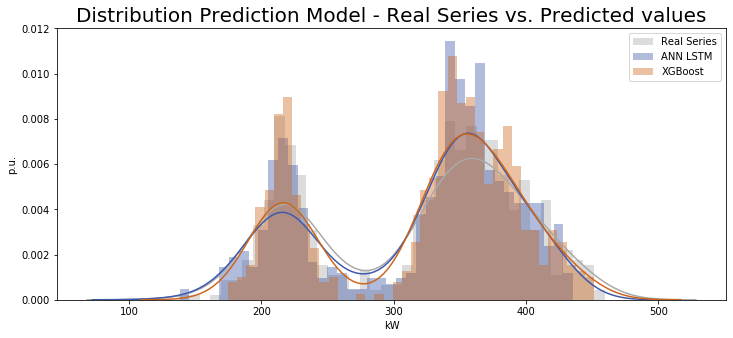

In [180]:
plt.figure(figsize=(12,5)) # Plot predictions and the real values together
sns.distplot(df_real, label='Real Series', bins=40, color='#A9A9A9')
sns.distplot(df_pred, label='ANN LSTM', bins=40, color='#3D59AB')
sns.distplot(df_pred_alt, label='XGBoost', bins=40, color='#CD661D')

plt.title("Distribution Prediction Model - Real Series vs. Predicted values", fontsize=20)
plt.legend()
plt.ylabel("p.u.")
plt.xlabel("kW");

Skewness ANN+LSTM = -1.76
Kurtosis ANN+LSTM = 7.80
Skewness XGBoost = -2.26
Kurtosis XGBoost = 8.76


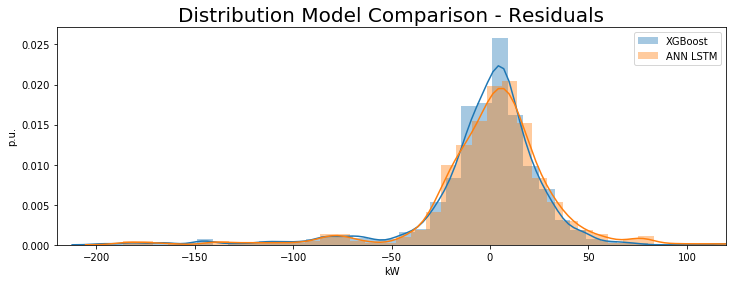

In [181]:
plt.figure(figsize=[12,4])
sns.distplot(model_alt_df['resid'], bins=40, label='XGBoost')
sns.distplot(model_2_df['resid'], bins=40, label='ANN LSTM')

plt.title('Distribution Model Comparison - Residuals', fontsize=20)
plt.xlabel("kW")
plt.xlim(-220,120)
plt.legend()
plt.ylabel("p.u.");

print("Skewness ANN+LSTM = %.2f" % model_2_df['resid'].skew())
print("Kurtosis ANN+LSTM = %.2f" % model_2_df['resid'].kurt())
print("Skewness XGBoost = %.2f" % model_alt_df['resid'].skew())
print("Kurtosis XGBoost = %.2f" % model_alt_df['resid'].kurt())

In [182]:
Model_alt_app = pd.DataFrame([model_alt_app_MAE, model_alt_app_RMSE, model_alt_app_EVS], columns = ['Model_alt_app'])
Model_alt = [model_alt_MAE, model_alt_RMSE, model_alt_EVS]
model_1_app = [model_1_app_MAE, model_1_app_RMSE, model_1_app_EVS ]
model_1 = [model_1_MAE, model_1_RMSE, model_1_EVS ]

Model_perf_df = pd.DataFrame(['ANN+LSTM',  'XGBoost','ANN+LSTM Applied', 'XGBoost Applied' ], columns = ['Model'])
Model_perf_df['MAE'] = [model_1_MAE, model_alt_MAE,model_1_app_MAE,model_alt_app_MAE ]
Model_perf_df['RMSE'] = [model_1_RMSE, model_alt_RMSE, model_1_app_RMSE, model_alt_app_RMSE ]
Model_perf_df['EVS'] = [model_1_EVS, model_alt_EVS,model_1_app_EVS, model_alt_app_EVS ]

Model_perf_df

,Model,MAE,RMSE,EVS
0,ANN+LSTM,12.17,17.87,0.95
1,XGBoost,12.16,17.95,0.93
2,ANN+LSTM Applied,21.76,34.43,0.80
3,XGBoost Applied,20.39,33.83,0.81


# The end!